# MOOC Analysis

This notebook conducts analysis on the trends of online learning through MOOC platforms with respect to developer trends at different skill levels

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 05/30/2025   | Martin | Create  | Notebook for analysis of MOOC data. Started visual summary of dataframe | 
| 06/02/2025   | Martin | Update  | Completed summary plots. To add explanations. Moving on to analysis| 
| 06/05/2025   | Martin | Update  | Completed assignment of skill level of responses in Stack Overflow dataset | 
| 06/08/2025   | Martin | Update  | Completed analysis. Need to update notebook structure | 

# Content

* [Introduction](#introduction)
* [Data](#data)
* [Summary Breakdown](#summary-breakdown)
* [Identify Skill Level in Developers](#identify-skill-level-in-developers)
* [Q1: Common Skills](#q1-common-skills)
* [Q2: Sufficient Courses](#q2-sufficient-courses)
* [Q3: Duration](#q3-duration)

# Introduction

The journey of a develop and data scientist is a never-ending thirst for new knowledge and upskilling. As new technologies are constantly being created, the onus is on us to continually update ourselves with new and relevant skills that are used within the industry. The rise of MOOC platforms has made picking up these skills much easier compared to the past. Courses cover a wide variety of topics from general overviews of a tool, to projects that aim to impart very specific skills.

The consensus in the community is that there are some fundamentals that should be developed before moving on to more advanced concepts. As such, the focus of this analysis is to identify the different trends related to the skills required at each level. We also compare this to the general programming community to see if the courses and projects offered by MOOC platforms are congruent with the skills in-demand by existing developers and data scientists

# Data

We are using the `combined_mooc.csv` and the (INSERT STACKOVERFLOW DATASET) as our primary dataframes to conduct this analysis

<u>Key points on MOOC dataset</u>
* 3 levels of skill encoded (Beginner, Intermediate, Advanced)

In [61]:
import ast
import nltk

import pandas as pd
import numpy as np
import pyarrow as pa
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from pywaffle import Waffle

In [4]:
try:
  print(stopwords.words('english'))
except Exception:
  nltk.download('stopwords')
  nltk.download('punkt_tab')
  print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [5]:
# Load MOOC data - some values are stored as lists and need to be converted back
df_mooc = pd.read_csv('combined_mooc.csv', low_memory=False)

cols_to_convert = ['skills', 'reviews', 'subject', 'reviews_comments', 'reviews_stars']
for col in cols_to_convert:
  df_mooc[col] = df_mooc[col].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else x)

In [6]:
df_mooc.head()

,type,course_name,organization,rating,description,skills,level,duration,reviews,enrollments,subject,provider,language,reviews_comments,reviews_stars,reviews_avg_stars,num_reviews,premium
0,course,AWS Lambda إنشاء صورة مصغرة بإستخدام السيرفرل...,Coursera Project Network,NaN,هذا المشروع التفاعلي -إنشاء صورة مصغرة بإستخدا...,"[AWS Identity And Access Management (IAM), Clo...",Intermediate,2.0,NaN,NaN,NaN,coursera,ar,NaN,NaN,NaN,NaN,NaN
1,course,Assisting Public Sector Decision Makers With ...,University of Michigan,4.8,Develop data analysis skills that support publ...,"[Simulations, Statistical Analysis, Predictive...",Intermediate,16.0,[{'comment': 'This course was very good at get...,NaN,NaN,coursera,en,[wonderful],[5],5.0,1.0,NaN
2,course,Advanced Strategies for Sustainable Business,University of Colorado Boulder,NaN,This course focuses on integrating sustainabil...,"[Circular Economy, Sustainable Business, Stake...",Beginner,6.0,NaN,NaN,NaN,coursera,en,NaN,NaN,NaN,NaN,NaN
3,course,Applying Machine Learning to Your Data with G...,Google Cloud,NaN,"Dans ce cours, nous définirons ce qu'est le ma...",NaN,Beginner,10.0,NaN,NaN,NaN,coursera,fr,NaN,NaN,NaN,NaN,NaN
4,project,Automate Blog Advertisements with Zapier,Coursera Project Network,NaN,Zapier is the industry leader in task automati...,"[Advertising, Social Media, Blogging, Marketing]",Intermediate,2.0,"[{'comment': 'wonderful', 'stars': 5}]",NaN,NaN,coursera,en,"[Very good way of teaching., Good, Good]","[5, 5, 5]",5.0,3.0,NaN


# Summary Breakdown

First we create a breakdown for some columns and derive some basic insights about the MOOC dataset

Summary bar plots - description to be added

In [7]:
# Data processing to generate plots
count_type = df_mooc['type'].value_counts()
count_type = pd.DataFrame(count_type).reset_index()

count_organization = df_mooc['organization'].value_counts()
count_organization = pd.DataFrame(count_organization).reset_index()
top_10_organization = count_organization.iloc[:10].sort_values('count')

count_level = df_mooc['level'].value_counts()
count_level = count_level.reindex(index=['Mixed', 'Advanced', 'Intermediate', 'Beginner'])
count_level = pd.DataFrame(count_level).reset_index()

count_provider = df_mooc['provider'].value_counts().sort_values()
count_provider = pd.DataFrame(count_provider).reset_index()

count_languages = df_mooc['language'].value_counts().sort_values()
count_languages = pd.DataFrame(count_languages).reset_index()
top_10_languages = count_languages.iloc[-10:]

count_premium = df_mooc['premium'].value_counts().sort_values()
count_premium = pd.DataFrame(count_premium).reset_index()
count_premium['premium'] = ['Free', 'Paid']

all_skills = np.concatenate(df_mooc['skills'].dropna().to_numpy())
all_skills = np.unique(all_skills, return_counts=True)
all_skills = {
  'skills': all_skills[0],
  'count': all_skills[1]
}
all_skills = pd.DataFrame(all_skills).sort_values('count')
top_20_skills = all_skills.iloc[-20:]

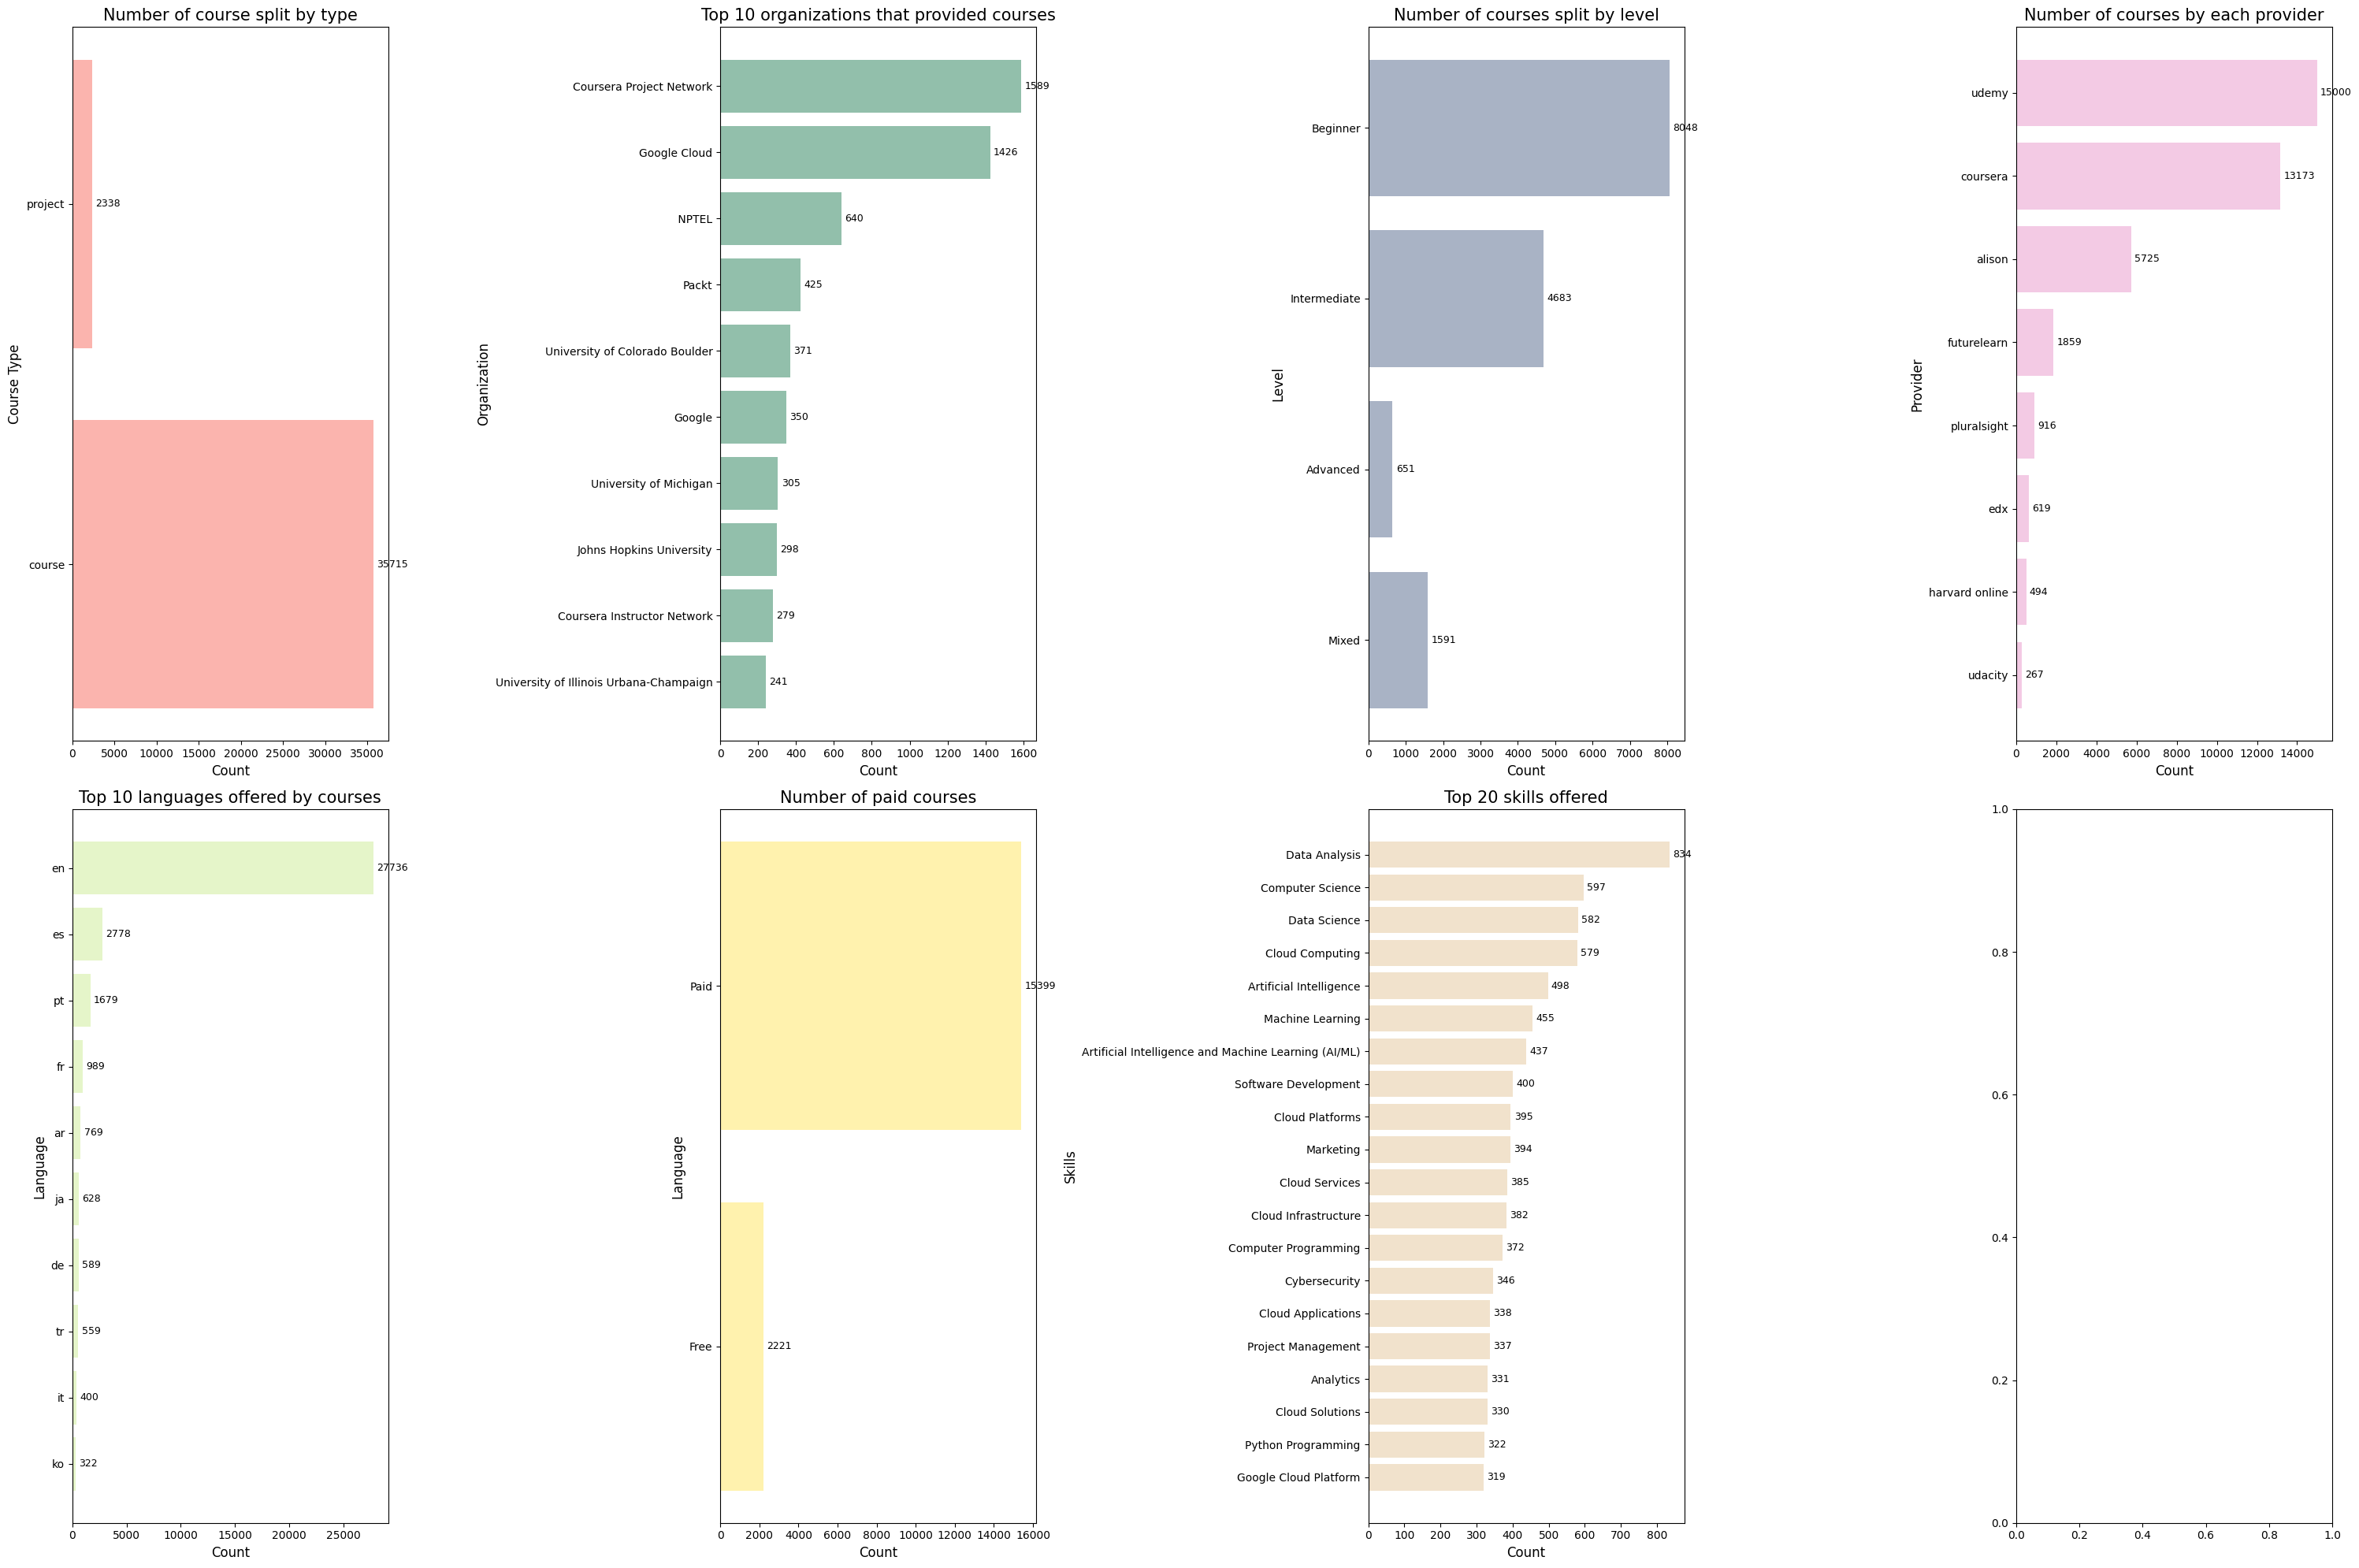

In [8]:
# Define global variables
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.cm.Pastel1.colors)
FS = 12

fig, ax = plt.subplots(nrows=2, ncols=4)
fig.set_figheight(20)
fig.set_figwidth(30)

# 1. Countplot of type column
bars = ax[0, 0].barh(count_type['type'], count_type['count'])
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 0].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 0].set_title("Number of course split by type", fontsize=FS+3)
ax[0, 0].set_ylabel("Course Type", fontsize=FS)
ax[0, 0].set_xlabel("Count", fontsize=FS)

# 2. Countplot of organisation column
bars = ax[0, 1].barh(top_10_organization['organization'], top_10_organization['count'], color="#92bfab")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 1].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 1].set_title("Top 10 organizations that provided courses", fontsize=FS+3)
ax[0, 1].set_ylabel("Organization", fontsize=FS)
ax[0, 1].set_xlabel("Count", fontsize=FS)

# 3. Countplot of level column
bars = ax[0, 2].barh(count_level['level'], count_level['count'], color="#a9b3c5")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 2].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 2].set_title("Number of courses split by level", fontsize=FS+3)
ax[0, 2].set_ylabel("Level", fontsize=FS)
ax[0, 2].set_xlabel("Count", fontsize=FS)

# 4. Countplot of provider column
bars = ax[0, 3].barh(count_provider['provider'], count_provider['count'], color="#f3cae4")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 3].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 3].set_title("Number of courses by each provider", fontsize=FS+3)
ax[0, 3].set_ylabel("Provider", fontsize=FS)
ax[0, 3].set_xlabel("Count", fontsize=FS)

# 5. Countplot of languages column
bars = ax[1, 0].barh(top_10_languages['language'], top_10_languages['count'], color="#e5f5c9")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[1, 0].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[1, 0].set_title("Top 10 languages offered by courses", fontsize=FS+3)
ax[1, 0].set_ylabel("Language", fontsize=FS)
ax[1, 0].set_xlabel("Count", fontsize=FS)

# 6. Countplot of premium column
bars = ax[1, 1].barh(count_premium['premium'], count_premium['count'], color="#fff2ae")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[1, 1].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[1, 1].set_title("Number of paid courses", fontsize=FS+3)
ax[1, 1].set_ylabel("Language", fontsize=FS)
ax[1, 1].set_xlabel("Count", fontsize=FS)

# 7. Top 20 skills
bars = ax[1, 2].barh(top_20_skills['skills'], top_20_skills['count'], color="#f1e2cc")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[1, 2].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[1, 2].set_title("Top 20 skills offered", fontsize=FS+3)
ax[1, 2].set_ylabel("Skills", fontsize=FS)
ax[1, 2].set_xlabel("Count", fontsize=FS)

fig.tight_layout()

Histogram plots - description to be added

In [9]:
def custom_hist_kde_plot(
  data: pd.Series,
  box_color: str,
  line_color: str,
  title: str,
  axes: list
):
  # Define the base histogram + kde plot
  plot = sns.histplot(data, kde=True, bins=40, color=box_color, line_kws={'color': 'red'}, ax=axes)
  plot.lines[0].set_color(line_color)
  plt.setp(plot.patches, linewidth=0.5)

  # Add the mean line
  mean = np.mean(data)
  plot.axvline(mean, color='#33a02c')
  scaled_x_pos = mean - 0.01 * mean
  scaled_y_pos = plot.get_ylim()[1] - 0.02*plot.get_ylim()[1]
  plot.text(scaled_x_pos, scaled_y_pos, f"Mean:\n{round(mean, 2)}", color='#33a02c', ha='right', va='top')

  # Add the median line
  median = np.median(data)
  plot.axvline(median, color='#1e78b4')
  scaled_x_pos = median - 0.01 * median
  scaled_y_pos = plot.get_ylim()[1] - 0.15*plot.get_ylim()[1]
  plot.text(scaled_x_pos, scaled_y_pos, f"Median:\n{round(median, 2)}", color='#1e78b4', ha='right', va='top')

  # Title
  plot.set_title(title)

  return plot

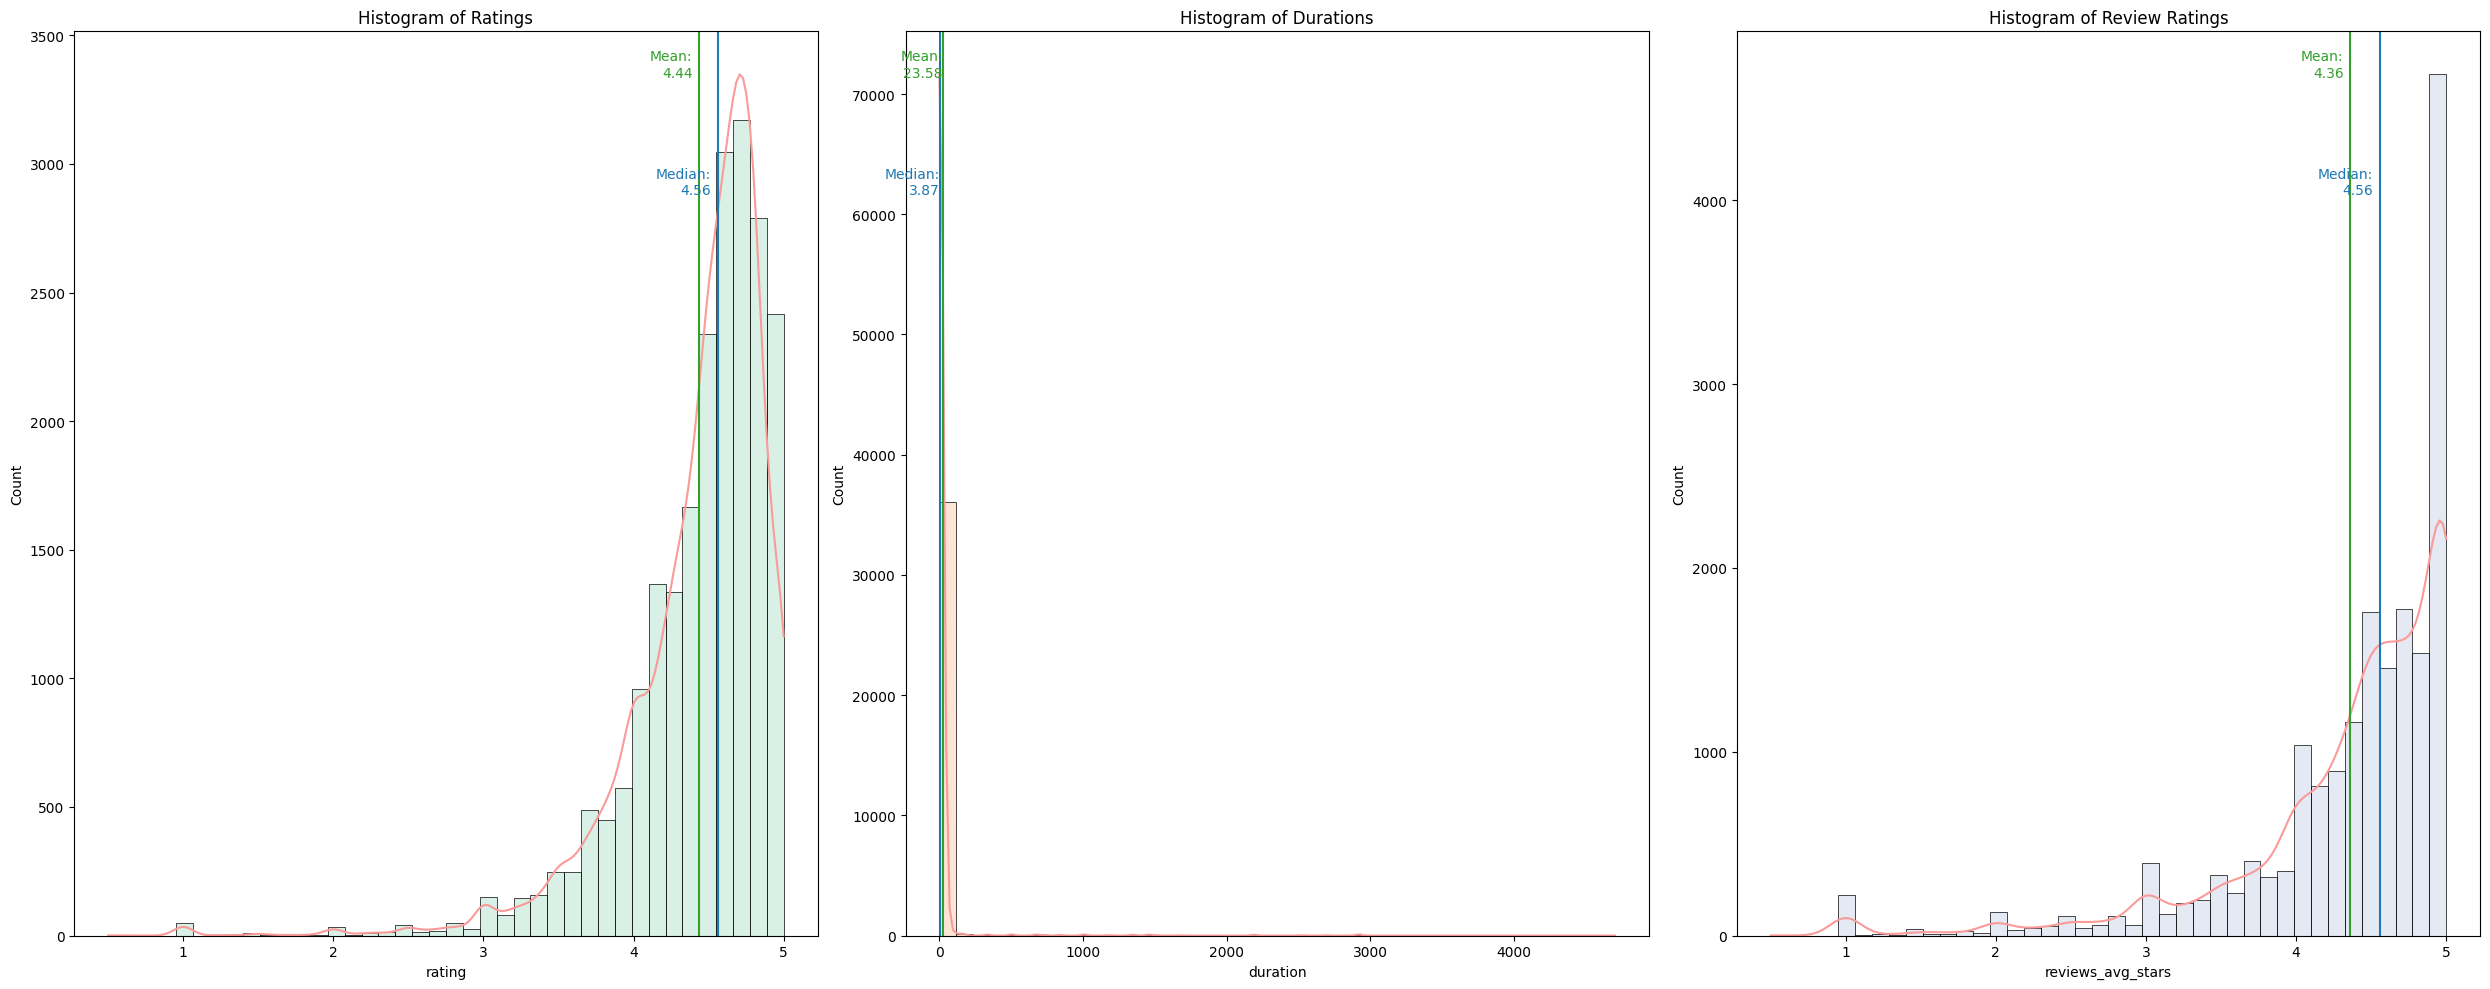

In [10]:
# Density based plots
ratings = df_mooc['rating'].dropna()
duration = df_mooc['duration'].dropna()
reviews_stars = df_mooc['reviews_avg_stars'].dropna()

# Define figure
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)

# Specify plots
custom_hist_kde_plot(ratings, box_color='#b3e2cd', line_color='#fa9a99', title='Histogram of Ratings', axes=ax[0])
custom_hist_kde_plot(duration, box_color='#fdcdac', line_color='#fa9a99', title='Histogram of Durations', axes=ax[1])
custom_hist_kde_plot(reviews_stars, box_color='#cbd5e8', line_color='#fa9a99', title='Histogram of Review Ratings', axes=ax[2])

fig.tight_layout()

Word Clouds - description to be added

NOTE: Every run is different for the wordcloud

In [11]:
# Use only english courses
course_desc = df_mooc[df_mooc['language'] == 'en']
course_desc = course_desc['description'].dropna().reset_index(drop=True)

# Randomly select 50 course descriptions
n = 50
np.random.seed(42)
idx = np.random.choice(range(course_desc.shape[0]), n)
course_desc = course_desc.iloc[idx]

# Merge descriptions into 1 large text
all_desc = ""
for sent in course_desc:
  all_desc += sent

# # Optional: Remove stop words
# word_tokens = word_tokenize(all_desc)
# stop_words = set(stopwords.words('english'))
# filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
# all_desc = " ".join(filtered_sentence)

(-0.5, 399.5, 199.5, -0.5)

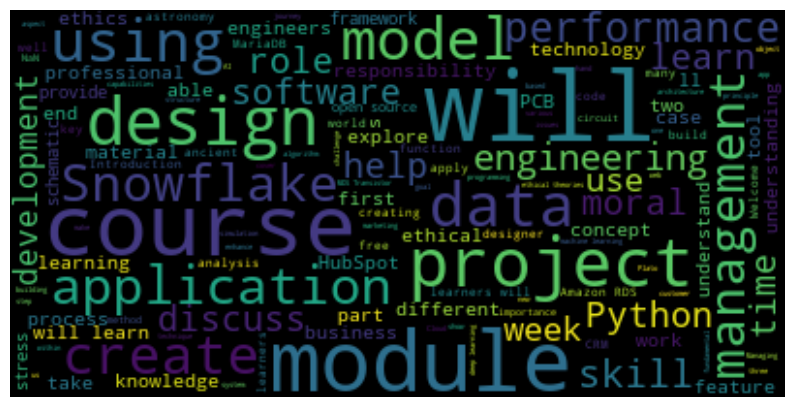

In [12]:
wordcloud = WordCloud(max_font_size=50).generate(all_desc)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [13]:
# For review comments
comments = df_mooc[df_mooc['language'] == 'en']
comments = comments['reviews_comments'].dropna()

# Randomly select 50 sets of comments
n = 50
np.random.seed(42)
idx = np.random.choice(range(comments.shape[0]), n)
comments = comments.iloc[idx]
comments = [i for j in comments.to_numpy() for i in j]

# Merge descriptions into 1 large text
all_desc = ""
for sent in comments:
  all_desc += sent

(-0.5, 399.5, 199.5, -0.5)

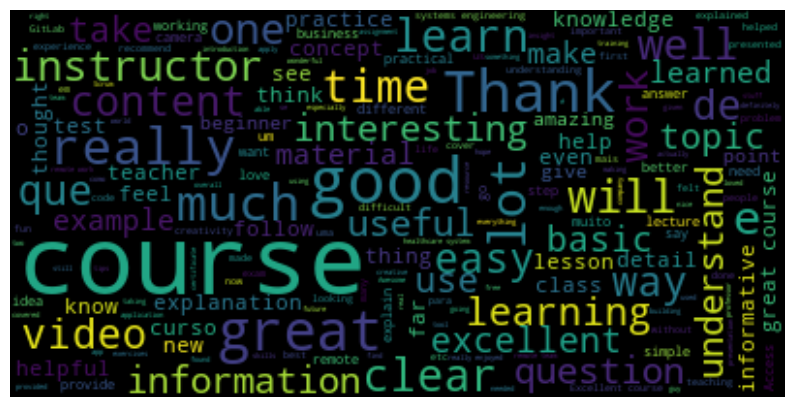

In [14]:
wordcloud = WordCloud(max_font_size=50).generate(all_desc)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

---

# Identify Skill Level in Developers 

Since the Stack Overflow survey has no measure of skill level, we define a reasonable set of rules that assigns a skill level to a developer based on their responses to the survey.

We focus on a few columns and define these rules:
* `CodingStatus` - Their current professional experience as a coder
* `YearsCoding` - Number of years they have spent coding
* `YearsProfessionalCoding` - Number of years they have spent coding professionally

Rules:
1. Respondants who are "Learning to Code are labelled as Beginners
2. Respondants who are "Coding as a hobby" are default Beginners, unless they are above the 75th percentile threshold then they are Intermediate
3. Respondants who are "Former developers" are default Intermediate they generally have much higher years of coding experience compared to other categories. If they are above the 25th percentile, they are Advanced
4. Respondants who are "Not primarily developers" are labelled as Intermediate if they are above the 50th percentile and Advanced if above the 75th percentile. We feel this group will still gain relevant experience which makes them proficient but probably in specialised areas, therefore the threshold to be of higher skill level is higher than those that are primarily developers
5. Respondants who are "Primarily developers" are labelled as Intermediate if they are above the 50th percentile and Advanced if above the 75th percentile.

Additional Notes:
* Many rules are created based on observing the quantile values and histogram distribution conditioned on the `CodingStatus`. Although this values could be considered arbitrary
* Majority of people are categorised as "Intermediate" which is to be expected since it's the default value

In [15]:
so = pd.read_csv("data/clean/survey_results.csv")

In [16]:
# Define rules for level assignment
def index_replace(l: list, ind: list, val: str) -> list:
  l[ind] = val
  return l

def perc(vals: list) -> (float, float, float):
  return np.percentile(vals, 25), np.percentile(vals, 50), np.percentile(vals, 75)

def assign_level(df: pd.DataFrame) -> pd.DataFrame:
  # Default value will be Intermediate
  sl = np.array(["Intermediate" for i in range(df.shape[0])])

  # Coding Status = Learner
  ind = df[df['CodingStatus'] == "I am learning to code"].index 
  sl = index_replace(sl, ind, "Beginner")

  # Coding Status = Hobby
  hobby = df[df['CodingStatus'] == "I code primarily as a hobby"]
  p25, p50, p75 = perc(hobby['YearsCoding'].dropna())
  sl = index_replace(sl, hobby.index, "Beginner") # Default value for this group is Beginner
  ind = hobby[hobby['YearsCoding'] >= p75].index
  sl = index_replace(sl, ind, "Intermediate") 

  # Coding Status = Used to be dev
  olddev = df[df['CodingStatus'] == "I used to be a developer by profession, but no longer am"]
  p25, p50, p75 = perc(olddev['YearsCoding'].dropna())
  sl = index_replace(sl, olddev.index, "Intermediate") # Default value for this group is Intermediate
  ind = olddev[olddev['YearsCoding'] > p25].index
  sl = index_replace(sl, ind, "Advanced") 

  # Coding Status = ptdev
  ptdev = df[df['CodingStatus'] == "I am not primarily a developer, but I write code sometimes as part of my work/studies"]
  p25, p50, p75 = perc(ptdev['YearsCodingProfessional'].dropna())
  sl = index_replace(sl, olddev.index, "Beginner") # Default value for this group is Beginner
  ind = ptdev[( ptdev['YearsCoding'] >= p50 ) & ( ptdev['YearsCoding'] < p75)].index
  sl = index_replace(sl, ind, "Intermediate") 
  ind = ptdev[ptdev['YearsCoding'] > p75].index
  sl = index_replace(sl, ind, "Advanced") 

  # Coding Status = dev
  dev = df[df['CodingStatus'] == "I am a developer by profession"]
  p25, p50, p75 = perc(dev['YearsCodingProfessional'].dropna())
  sl = index_replace(sl, olddev.index, "Beginner") # Default value for this group is Beginner
  ind = dev[( dev['YearsCoding'] >= p25 ) & ( dev['YearsCoding'] < p75)].index
  sl = index_replace(sl, ind, "Intermediate") 
  ind = dev[dev['YearsCoding'] > p75].index
  sl = index_replace(sl, ind, "Advanced") 

  return sl

In [17]:
# Take a subset of columns to define skill level
sub = so[['CodingStatus', 'AgeRange', 'CodingActivities', 'YearsCoding', 'YearsCodingProfessional', 'YearsWorkExperience']]

# YearsCoding and YearsCodingProfessional have <1 and >50 as values
# Replace these with 0 and 51 respectively to make data numerical for binning
sub.loc[sub['YearsCoding'] == "Less than 1 year", "YearsCoding"] = 0
sub.loc[sub['YearsCoding'] == "More than 50 years", "YearsCoding"] = 50
sub['YearsCoding'] = sub['YearsCoding'].astype(float)
sub.loc[sub['YearsCodingProfessional'] == "Less than 1 year", "YearsCodingProfessional"] = 0
sub.loc[sub['YearsCodingProfessional'] == "More than 50 years", "YearsCodingProfessional"] = 50
sub['YearsCodingProfessional'] = sub['YearsCodingProfessional'].astype(float)

# Assign skill level
skill_level = assign_level(sub)
so['SkillLevel'] = skill_level

C:\Users\User\AppData\Local\Temp\ipykernel_32764\1658121313.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['YearsCoding'] = sub['YearsCoding'].astype(float)
C:\Users\User\AppData\Local\Temp\ipykernel_32764\1658121313.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['YearsCodingProfessional'] = sub['YearsCodingProfessional'].astype(float)


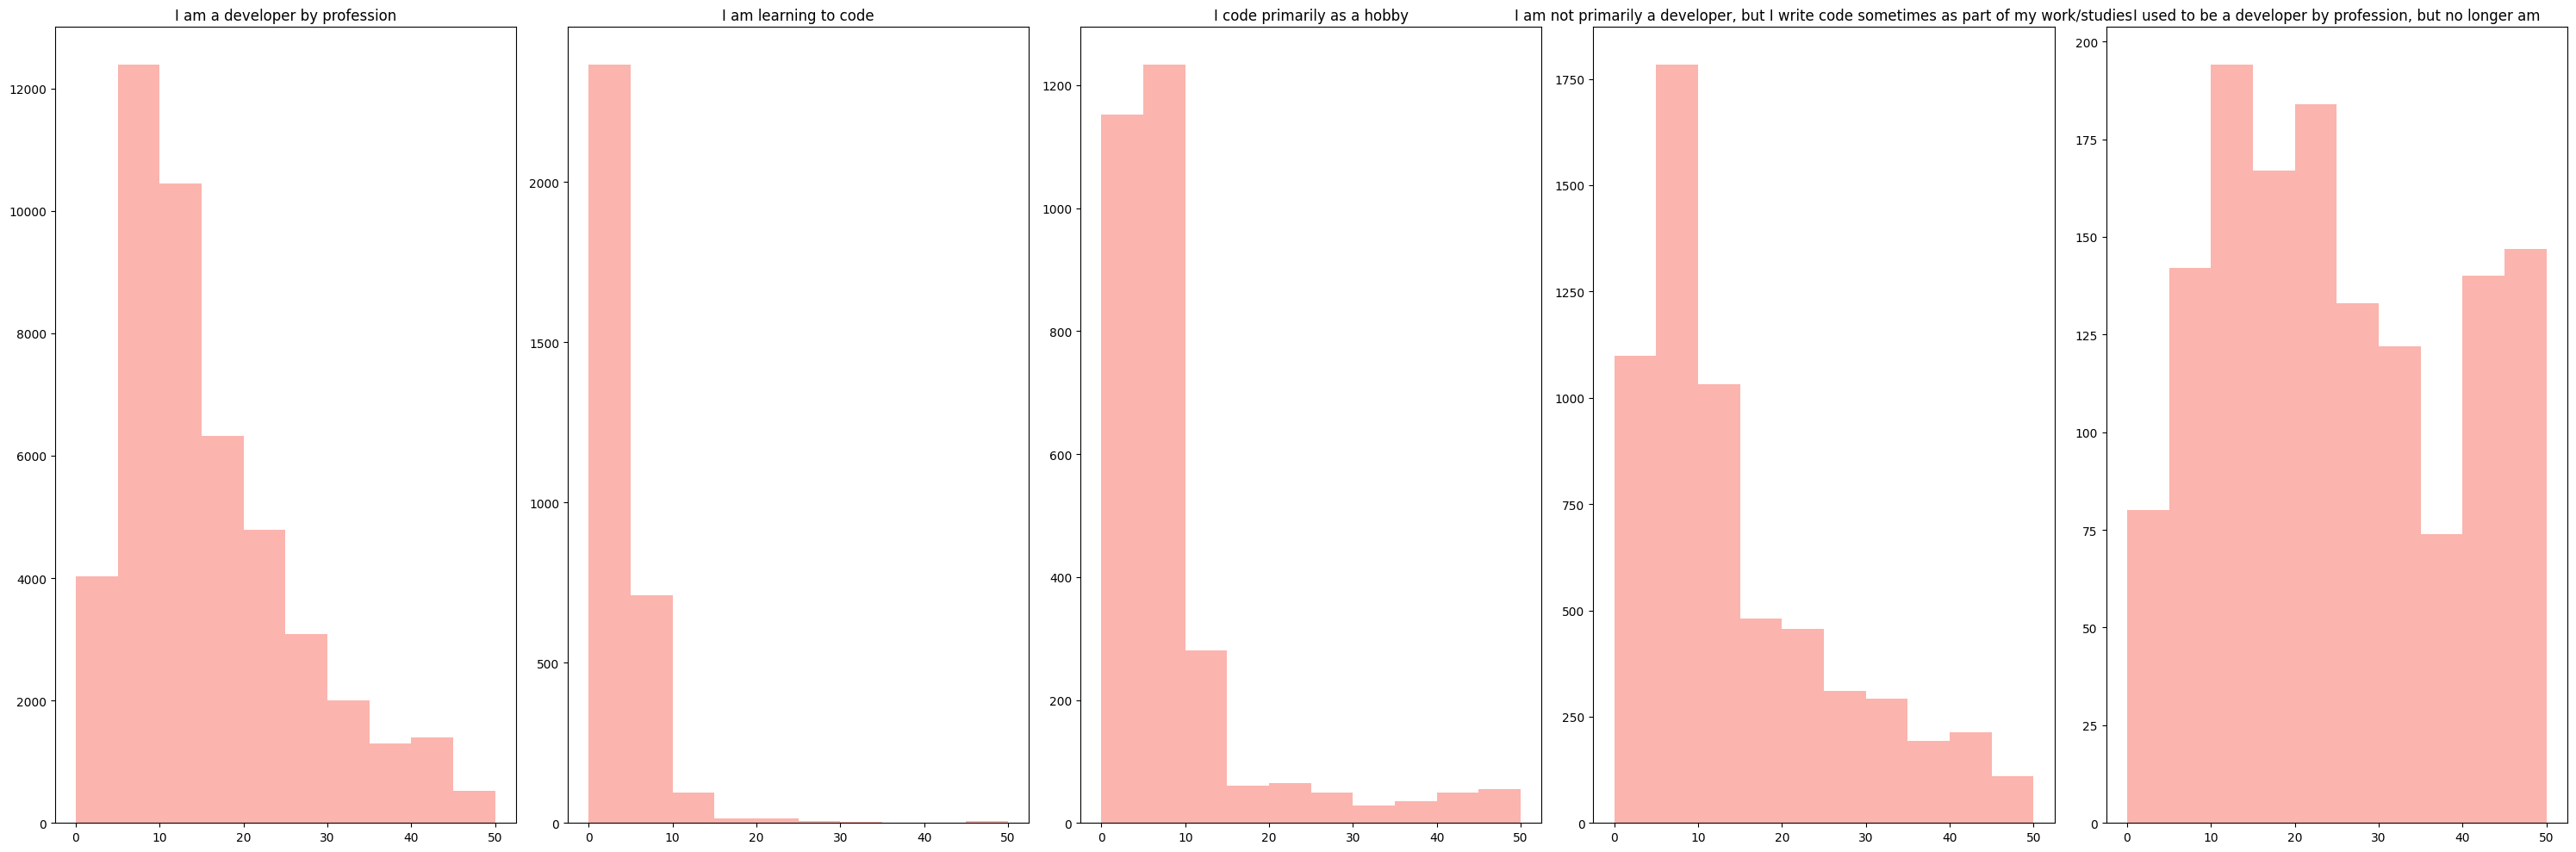

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_figheight(10)
fig.set_figwidth(30)

status = sub['CodingStatus'].unique()
for i in range(len(status)):
  ax[i].hist(sub[sub['CodingStatus'] == status[i]]['YearsCoding'])
  ax[i].set_title(status[i])

fig.tight_layout()

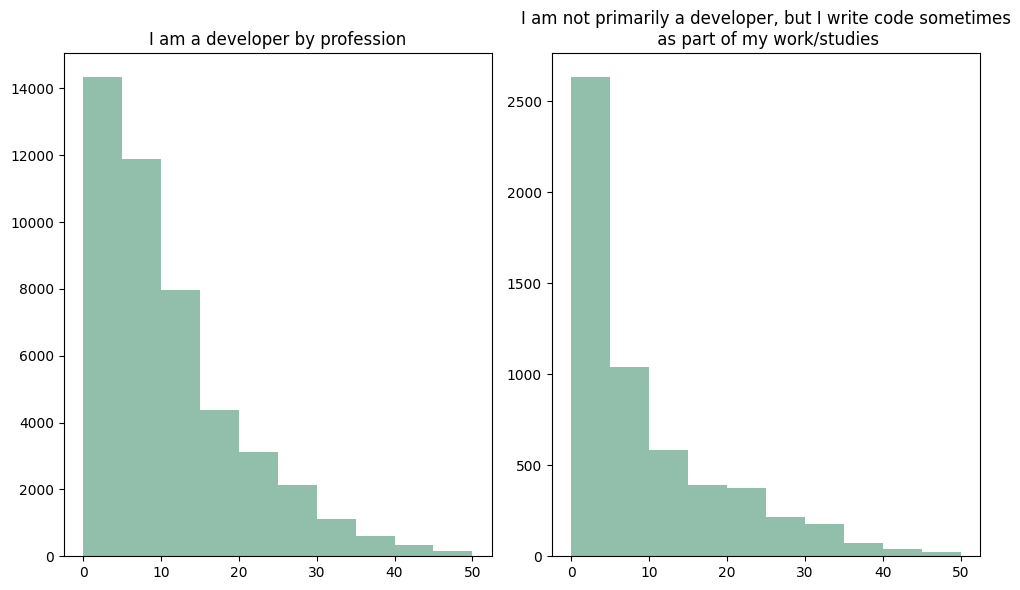

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(10)

status = ['I am a developer by profession', 'I am not primarily a developer, but I write code sometimes\n as part of my work/studies']
for i in range(len(status)):
  ax[i].hist(sub[sub['CodingStatus'] == status[i].replace('\n', '')]['YearsCodingProfessional'], color="#92bfab")
  ax[i].set_title(status[i])

fig.tight_layout()

# Q1: Common Skills

This first question wonders what are the top skills and tools developers of different skill levels are interested in? 

Since we have mapped each respondents skill level, we now count the skills in each category that each developer of the respective level have used in the past year. We then rank the top 5 most popular skills

In [20]:
cols = [
  'SkillLevel',
  'HowLearnCode',
  'HowLearnCodeOnline',
  'LanguagesUsedPastYear',
  'DatabasesUsedPastYear',
  'PlatformsUsedPastYear',
  'WebFramworksUsedPastYear'
]
so_skills = so[cols]

In [21]:
# Convert to column values to lists
for col in cols[1:]:
  so_skills[col] = so_skills[col].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else x)

C:\Users\User\AppData\Local\Temp\ipykernel_32764\2819322342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  so_skills[col] = so_skills[col].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else x)


In [22]:
so_skills.head()

,SkillLevel,HowLearnCode,HowLearnCodeOnline,LanguagesUsedPastYear,DatabasesUsedPastYear,PlatformsUsedPastYear,WebFramworksUsedPastYear
0,Intermediate,[Books / Physical media],NaN,NaN,NaN,NaN,NaN
1,Advanced,"[Books / Physical media, Colleague, On the job...","[Technical documentation, Blogs, Books, Writte...","[Bash/Shell (all shells), Go, HTML/CSS, Java, ...","[Dynamodb, MongoDB, PostgreSQL]","[Amazon Web Services (AWS), Heroku, Netlify]","[Express, Next.js, Node.js, React]"
2,Advanced,"[Books / Physical media, Colleague, On the job...","[Technical documentation, Blogs, Books, Writte...",[C#],[Firebase Realtime Database],[Google Cloud],[ASP.NET CORE]
3,Beginner,"[Other online resources (e.g., videos, blogs, ...","[Stack Overflow, How-to videos, Interactive tu...","[C, C++, HTML/CSS, Java, JavaScript, PHP, Powe...","[MongoDB, MySQL, PostgreSQL, SQLite]","[Amazon Web Services (AWS), Fly.io, Heroku]","[jQuery, Next.js, Node.js, React, WordPress]"
4,Intermediate,"[Other online resources (e.g., videos, blogs, ...","[Technical documentation, Blogs, Written Tutor...","[C++, HTML/CSS, JavaScript, Lua, Python, Rust]","[PostgreSQL, SQLite]",NaN,NaN


There are 4 columns that categorise different types of technologies:

1. Programming Languages
2. Databases
3. Cloud Platforms
4. Web Frameworks

For each type, we will extract the top 5 by count for each skill level of respondents. These will represent the most "popular" skills as demanded in the past year. We will plot this in a bar graph

In [23]:
skills_cols = {
  'LanguagesUsedPastYear': 'Languages',
  'DatabasesUsedPastYear': 'Databases',
  'PlatformsUsedPastYear': 'Cloud Platforms',
  'WebFramworksUsedPastYear': 'Web Frameworks'
}

In [24]:
def get_top_5_tech(df: pd.DataFrame, col: str) -> pd.DataFrame:
  df1 = df[col]
  df1 = df1.dropna().astype(pd.ArrowDtype(pa.list_(pa.string())))
  df1 = df1.list.flatten()
  df1 = df1.value_counts().sort_values()[-5:]
  df1 = pd.DataFrame(df1).reset_index()

  return df1

Now we create a combined plot of the top skills for each skills category at the selected level

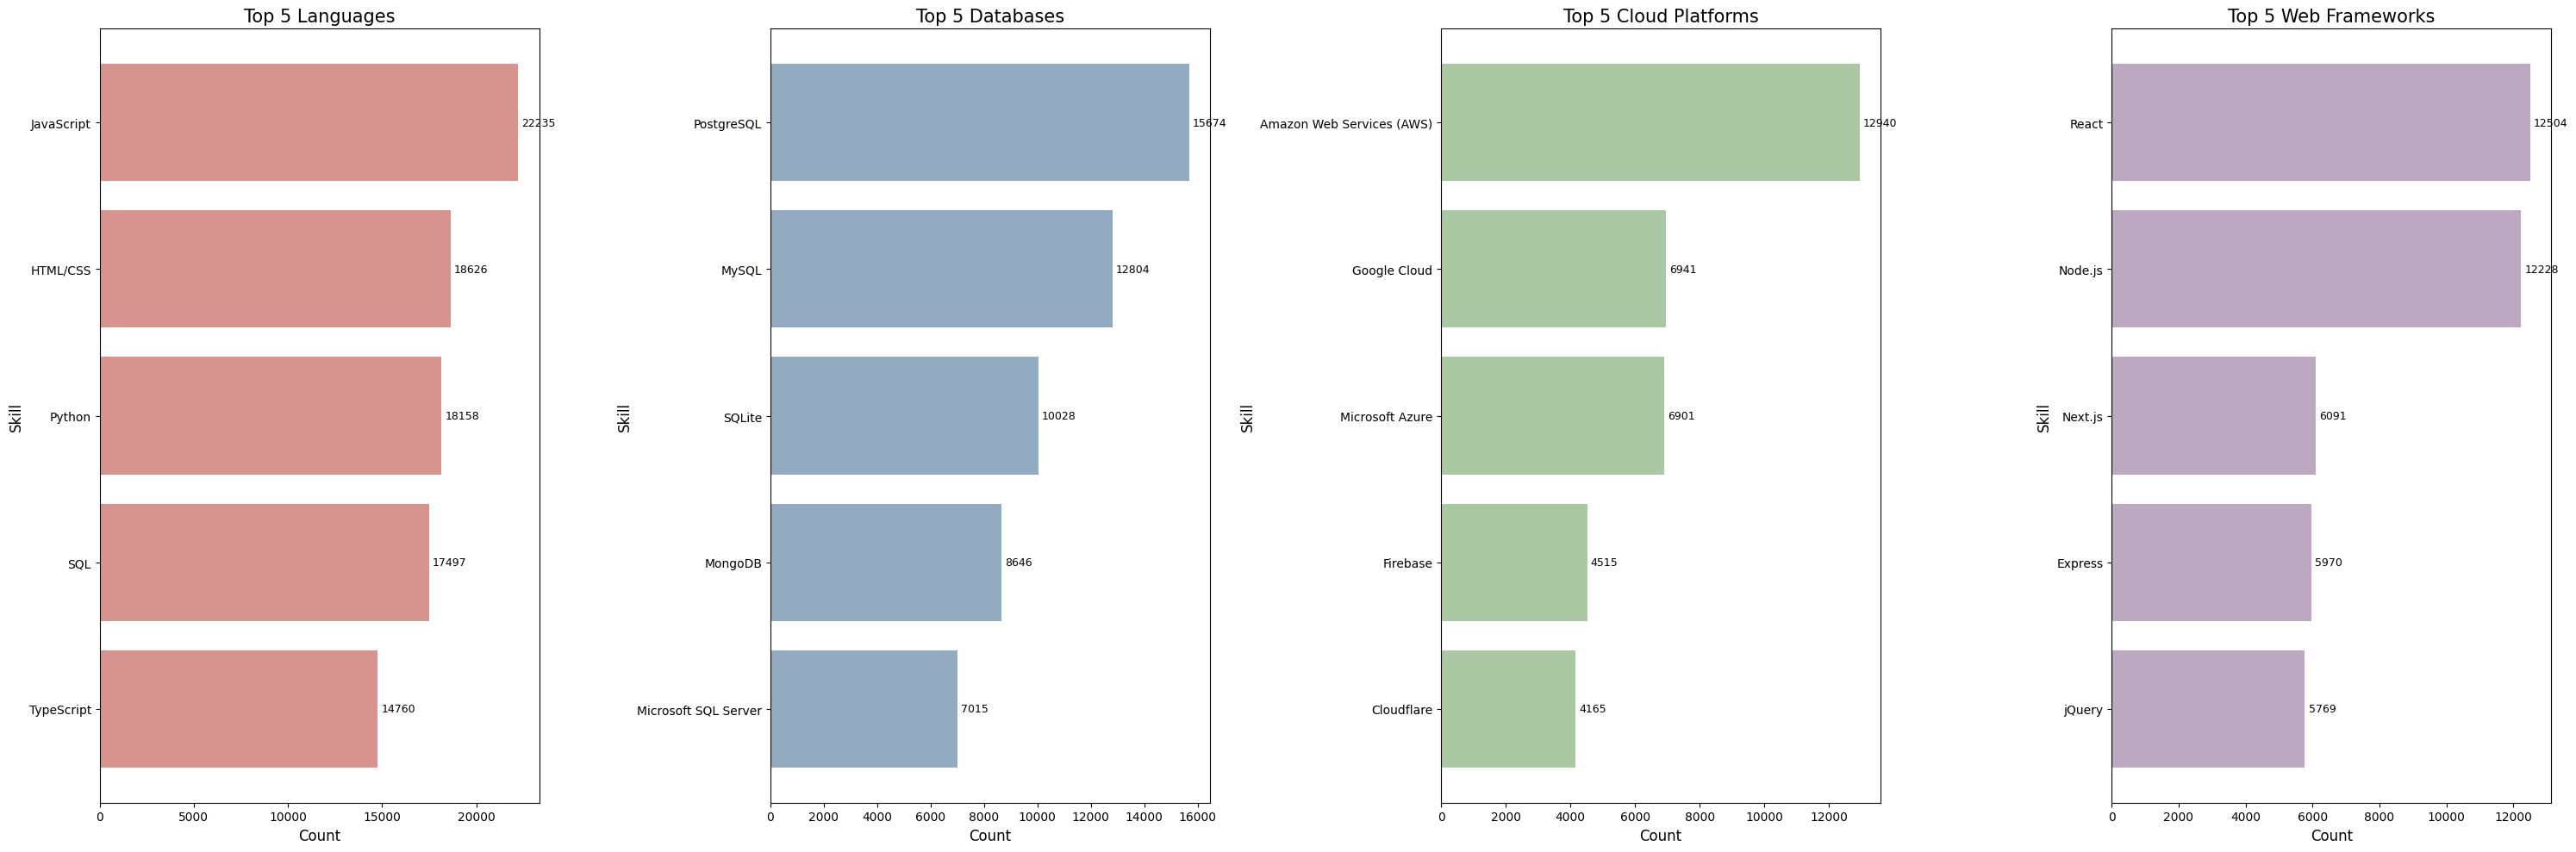

In [63]:
# Overarching skill level
LEVEL = "Intermediate"

# Split data by skill level
df_skill = so_skills[so_skills['SkillLevel'] == LEVEL]

# Setup diagram for plotting
fig, ax = plt.subplots(nrows=1, ncols=4)
fig.set_figheight(10)
fig.set_figwidth(30)

colours = ["#d7938e", "#92abc0", "#aac8a4", "#bca9c1"]
for i in range(len(skills_cols)):
  # Get top 5 technologies for each category
  dfp = get_top_5_tech(df_skill, list(skills_cols.keys())[i])

  # Plot
  bars = ax[i].barh(dfp['index'], dfp['count'], color=colours[i])
  for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax[i].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
  ax[i].set_title(f"Top 5 {skills_cols[list(skills_cols.keys())[i]]}", fontsize=FS+3)
  ax[i].set_ylabel("Skill", fontsize=FS)
  ax[i].set_xlabel("Count", fontsize=FS)

fig.tight_layout()

## Limitations

* Definition of skill level is based on our rules which might not be reflective of the actual definition of skill level

# Q2: Sufficient Courses

Our next question would then be, are there sufficient courses offered by online courses to reflect those that developers have used in the past year?

To measure whether courses provide the necessary courses for each of these top 5 skills, we perform a naive matching of skill labels to the Course Name, Description, Skills and Organization based on the level of the developer.

There are many different names for various technologies (e.g Amazon Web Service, AWS, AWS Cloud, and many of the different services) as such we might not match every instance across every course. But this naive approach provides a preliminary idea of the number of courses that match the skills used by developers over the past year.

In [26]:
# Combine the text columns
df_mooc['desc_comb'] = ""
for i in range(df_mooc.shape[0]):
  try:
    df_mooc.loc[i, 'desc_comb'] = " ".join(
      df_mooc['skills'][i] + 
      [df_mooc['description'][i]] + 
      [df_mooc['course_name'][i]] +
      [df_mooc['organization'][i]]
    )
  except Exception:
    df_mooc.loc[i, 'desc_comb'] = " ".join([
      str(df_mooc['description'][i]),
      str(df_mooc['course_name'][i]),
      str(df_mooc['organization'][i])
    ])

Here we assign $1$ to a course if the skill exists in the combined description containing skills, course description, organisation and name. $0$ otherwise.

In [82]:
# Maps different technology names to their alternative names for more comprehensive matching
skills_mapper = {
  'html/css': ['html/css', 'html', 'css'],
  'microsoft sql server': ['microsoft sql server', 'sql server'],
  'amazon web services (aws)': ['amazon web services (aws)', 'aws'],
  'google cloud': ['google cloud', 'gcloud', 'gcp'],
  'node.js': ['node.js', 'nodejs', 'node'],
  'next.js': ['next.js', 'nextjs']
}

def map_skills_to_courses(df: pd.DataFrame, level: str | None, skill_type: str) -> pd.DataFrame:
  # Get top 5 skills in a list
  if level is not None:
    df_skills = df[df['level'] == level].reset_index()
  else:
    df_skills = df
  dfp = get_top_5_tech(df_skill, skill_type)
  skills = dfp['index'].to_list()

  # Create a column that represents if the skill_match is in the combined description
  for skill in skills:
    skill_match = skill.lower()

    # Check if there is an alternative name in the skills_mapper
    vals = []
    if skill_match in skills_mapper.keys():
      skill_match = skills_mapper[skill_match]

    # If the type is a string, do a direct match with every word
    # If it is a list, check if any value in the list matches
    if isinstance(skill_match, str):
      for i in range(df_skills.shape[0]):
        to_match = df_skills.loc[i, 'desc_comb'].lower().split(' ')
        if skill_match in to_match:
          vals.append(1)
        else:
          vals.append(0)
    else:
      for i in range(df_skills.shape[0]):
        to_match = df_skills.loc[i, 'desc_comb'].lower().split(' ')
        if any(value in to_match for value in skill_match):
          vals.append(1)
        else:
          vals.append(0)

    df_skills[skill] = vals   

  return df_skills

Now we can compare within the selected skill level and skill category

<u>Skill Level</u>

1. Beginner
2. Intermediate
3. Advanced

<u>Skills Category</u>

1. Languages
2. Databases
3. Cloud Platforms
4. Web Frameworks

In [83]:
LEVEL = "Intermediate"
SKILL_CAT = "Languages"

rev_map = {v:k for k, v in skills_cols.items()}
st = rev_map[SKILL_CAT]
course_skills = map_skills_to_courses(df_mooc, LEVEL, st)

# Separate out the columns which show matched values and sum them together
course_cols = course_skills.columns[-5:]
matched_courses = course_skills[course_cols]
matched_courses = matched_courses.sum().reset_index()
matched_courses.columns = ['skills', 'count']
matched_courses.loc[len(matched_courses)] = ['Others', len(course_skills) - sum(matched_courses['count'])]
matched_courses['perc'] = (matched_courses['count'] / len(course_skills)) * 100
matched_courses

,skills,count,perc
0,TypeScript,15,0.320307
1,SQL,229,4.890028
2,Python,406,8.669656
3,HTML/CSS,133,2.840060
4,JavaScript,187,3.993167
5,Others,3713,79.286782


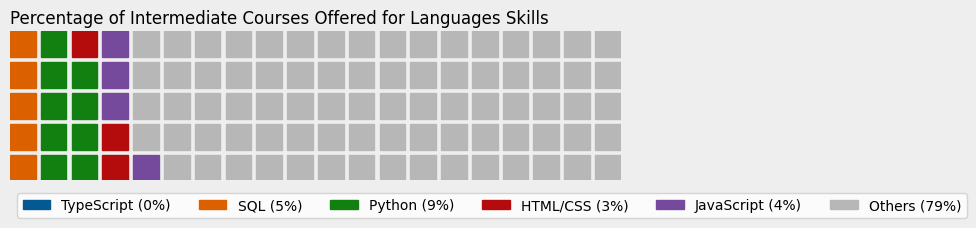

In [84]:
data = {k: v for k, v in zip(matched_courses['skills'], matched_courses['perc'])}
fig = plt.figure(
  FigureClass=Waffle,
  rows=5,
  values=data,
  colors=("#045993", "#db6000", "#118011", "#b40c0d", "#75499c", "#b7b7b7"),
  title={'label': f"Percentage of {LEVEL} Courses Offered for {SKILL_CAT} Skills", 'loc': 'left'},
  labels=[f"{k} ({round(v)}%)" for k, v in data.items()],
  legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.3), 'ncol': len(data)},
  figsize=(9, 5)
)

fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('#EEEEEE')
plt.show()

## Limitations

- Exact string matching is not the best method to find relationships between courses and skills. There are some skills that end up not getting matched (e.g "Microsoft SQL Server" because it's too specific).
  * A better method would be to encode textual information numericals (e.g word embeddings) and use a similary score to measure "closeness" of each skill to the course description
  * Semantically these would be more similar since the numerical representation would also capture more distinct features of th language used
- Many different representation of skills:
  * Skill naming might be different (e.g Javascript, JS, JScript)
  * Skill names being technologies might not be captured in course description (e.g Javascript is usually used for web development, but we will not match web development courses because the description might not contain the "Javasript" term)
- Many more non-developer related courses

# Q3: Duration

Finally, one assumption we have is that more advanced topics would take longer to learn. So for each skill level does this assumption hold for the different skills developers have listed?

As a proxy, we use the course duration to determine the "time it takes to learn that skill". Obviously, this is not the best metric, but given that these courses are curated by institutions and experts, we would assume that the course length is a good estimate to how long it would take to pick up these skills.

In [88]:
SKILL_CAT = "Languages"

rev_map = {v:k for k, v in skills_cols.items()}
st = rev_map[SKILL_CAT]
all_course_skills = map_skills_to_courses(df_mooc, None, st)
l_skills = all_course_skills.columns[-5:]

print("The list of skills to choose from are:")
for i in range(len(l_skills)):
  print(f"{i+1}: {l_skills[i]}")

The list of skills to choose from are:
1: TypeScript
2: SQL
3: Python
4: HTML/CSS
5: JavaScript


(-20.0, 200.0)

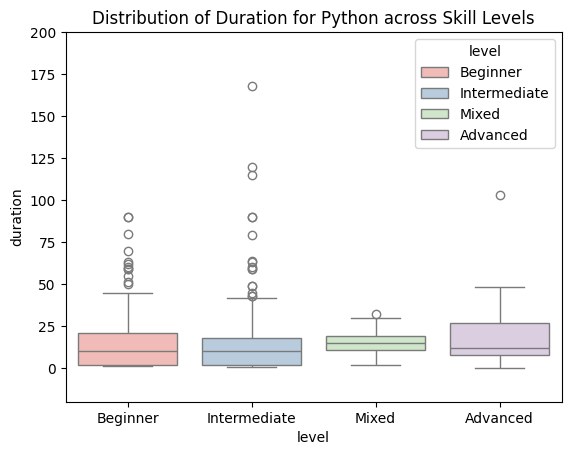

In [105]:
SKILL = "Python"

# Subset the data based on skill selected
df_duration = all_course_skills[['duration', 'level', SKILL]]
df_duration = df_duration[df_duration[SKILL] == 1]

sns.boxplot(
  data=df_duration,
  x='level',
  y='duration',
  hue='level'
)
plt.title(f"Distribution of Duration for {SKILL} across Skill Levels")
plt.ylim(-20, 200)

Many other assumptions, course coverage is different